# Train - AutoML




In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager

import lightgbm as lgb
from xgboost import XGBClassifier

from glob import glob
from tqdm import tqdm
from typing import List, Dict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier



from pycaret.classification import *

import warnings
warnings.filterwarnings(action='ignore')


# 사용 가능한 폰트 목록 출력
# print([f.name for f in matplotlib.font_manager.fontManager.ttflist])

# 특정 폰트 지정
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
''' 
에러 발생 및 해결 방법

ImportError: cannot import name '_format_load_msg' from 'joblib.memory' (/opt/conda/envs/automl/lib/python3.8/site-packages/joblib/memory.py)

'''
# !pip install --upgrade 'joblib<1.4' pycaret

" \n에러 발생 및 해결 방법\n\nImportError: cannot import name '_format_load_msg' from 'joblib.memory' (/opt/conda/envs/automl/lib/python3.8/site-packages/joblib/memory.py)\n\n"

In [3]:
''' 
train_df = train_label + train_data
test_df = test_label + test_data

all_df = all_label + all_data
'''

dir_path = "/data/ephemeral/home/data"

data_path = "./data.csv"
all_df = pd.read_csv(data_path)

train_df = all_df.loc[all_df["_type"]=="train"].drop(columns=["_type"])
test_df = all_df.loc[all_df["_type"]=="test"].drop(columns=["_type"])
print("data shape: ", all_df.shape)
print("train shape: ", train_df.shape)
print("test shape: ", test_df.shape)

y = train_df['target']    # fetures
x = train_df.drop(['ID', 'target'], axis=1)    # target

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

data shape:  (11552, 509)
train shape:  (8760, 508)
test shape:  (2792, 508)
(7008, 506) (7008,)
(1752, 506) (1752,)


In [ ]:
# # 파일 호출
# data_path: str = "/data/ephemeral/home/data"
# train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
# test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
# submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
# df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

# # HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
# file_names: List[str] = [
#     f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
# ]

# # 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
# file_dict: Dict[str, pd.DataFrame] = {
#     f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
# }

# for _file_name, _df in tqdm(file_dict.items()):
#     # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
#     _rename_rule = {
#         col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
#         for col in _df.columns
#     }
#     _df = _df.rename(_rename_rule, axis=1)
#     df = df.merge(_df, on="ID", how="left")

# cols_dict: Dict[str, str] = {
#     "ID": "ID",
#     "target": "target",
#     "_type": "_type",
#     "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
#     "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
#     "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
#     "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
#     "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
#     "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
#     "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
#     "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
#     "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
#     "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
#     "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
#     "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
#     "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
#     "hourly_network-data_addresses-count_addresses_count_active": "active_count",
#     "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
#     "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
#     'hourly_network-data_hashrate_hashrate': "hashrate_value",
#     'hourly_network-data_transactions-count_transactions_count_total': 'transaction_count',
#     'hourly_network-data_velocity_velocity_supply_total': 'velocity_count'
# }
# df = df[cols_dict.keys()].rename(cols_dict, axis=1)
# df.shape


# # eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
# df = df.assign(
#     liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
#     liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
#     volume_diff=df["buy_volume"] - df["sell_volume"],
#     liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
#     liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
#     volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
#     buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
# )

# df['buy_volume_ma_3h'] = df['buy_volume'].rolling(window=3).mean()
# df['buy_volume_std_3h'] = df['buy_volume'].rolling(window=3).std()

# df['funding_rates_ma_3h'] = df['funding_rates'].rolling(window=3).mean()
# df['funding_rates_std_3h'] = df['funding_rates'].rolling(window=3).std()

# df['price_close_pct_change_1h'] = 100*(df['coinbase_premium_gap']-df['coinbase_premium_gap'].shift(1))/(df['coinbase_premium_gap'].shift(1)+100)
# df['price_close_pct_change_3h'] = 100*(df['coinbase_premium_gap']-df['coinbase_premium_gap'].shift(3))/(df['coinbase_premium_gap'].shift(3)+100)

# df['buy_volume_pct_change_1h'] = 100*(df['buy_volume']-df['buy_volume'].shift(1))/(df['buy_volume'].shift(1)+1)
# df['buy_volume_pct_change_3h'] = 100*(df['buy_volume']-df['buy_volume'].shift(3))/(df['buy_volume'].shift(3)+1)

# df['liquidation_diff_pct_change_3h'] = 100*(df['liquidation_diff']-df['liquidation_diff'].shift(3))/(df['liquidation_diff'].shift(3)+1)

# # df['buy_sell_ratio_pct_change_3h'] = df['buy_sell_ratio'].pct_change(periods=3)
# df['is_buy_dominant'] = (df['buy_sell_ratio'] > 1.0).astype(int)
# df['volume_diff_pct_change_12h'] = df['volume_diff'].pct_change(periods=12)
# df['volume_diff_pct_change_6h'] = df['volume_diff'].pct_change(periods=6)
# df['volume_diff_pct_change_additive']=df['volume_diff_pct_change_6h']+df['volume_diff_pct_change_12h'] # star
# df['mean_7days'] = df['volume_diff'].rolling(window=168).mean()  # 7 days if hourly data
# df['mean_1day'] = df['volume_diff'].rolling(window=24).mean()    # 1 day if hourly data
# df['slope_7days'] = df['mean_7days'].diff()
# df['slope_1day'] = df['mean_1day'].diff()
# df['slope_change']=df['slope_7days']-df['slope_1day'] # star
# df.drop(columns=['mean_7days', 'mean_1day','volume_diff_pct_change_12h','volume_diff_pct_change_6h'], inplace=True)



# # df['volume_diff_pct_change_12h'] = df['volume_diff'].pct_change(periods=12)
# # df['volume_diff_pct_change_6h'] = df['volume_diff'].pct_change(periods=6)
# # df['volume_diff_pct_change_additive']=df['volume_diff_pct_change_6h']+df['volume_diff_pct_change_12h'] # star
# # df['mean_7days'] = df['volume_diff'].rolling(window=168).mean()  # 7 days if hourly data
# # df['mean_1day'] = df['volume_diff'].rolling(window=24).mean()    # 1 day if hourly data
# # df['slope_7days'] = df['mean_7days'].diff()
# # df['slope_1day'] = df['mean_1day'].diff()
# # df['slope_change']=df['slope_7days']-df['slope_1day'] # star
# # df.drop(columns=['mean_7days', 'mean_1day'], inplace=True)

# # category, continuous 열을 따로 할당해둠
# category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
# conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
#     "buy_sell_volume_ratio", "liquidation_diff", "liquidation_usd_diff", "volume_diff",
#     "buy_volume_ma_3h", "buy_volume_std_3h", "funding_rates_ma_3h", "funding_rates_std_3h",
#     "price_close_pct_change_1h", "price_close_pct_change_3h", "buy_volume_pct_change_1h", "buy_volume_pct_change_3h",
#     "liquidation_diff_pct_change_3h", "is_buy_dominant"
# ]


# def shift_feature(
#     df: pd.DataFrame,
#     conti_cols: List[str],
#     intervals: List[int],
# ) -> List[pd.Series]:
#     """
#     연속형 변수의 shift feature 생성
#     Args:
#         df (pd.DataFrame)
#         conti_cols (List[str]): continuous colnames
#         intervals (List[int]): shifted intervals
#     Return:
#         List[pd.Series]
#     """
#     df_shift_dict = [
#         df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
#         for conti_col in conti_cols
#         for interval in intervals
#     ]
#     return df_shift_dict

# # 최대 24시간의 shift 피쳐를 계산
# shift_list = shift_feature(
#     df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
# )


# # concat 하여 df 에 할당
# df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# # 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
# _target = df["target"]
# df = df.ffill().fillna(-999).assign(target = _target)

# # _type에 따라 train, test 분리
# train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
# test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])






# def window_slicing(df: pd.DataFrame, window_size: int, step_size: int) -> pd.DataFrame:
#     sliced_data = []
    
#     for start in range(0, len(df) - window_size + 1, step_size):
#         end = start + window_size
#         window_df = df.iloc[start:end].copy()
#         # window_df['window_start_index'] = start
#         sliced_data.append(window_df)
    
#     sliced_data_df = pd.concat(sliced_data, axis=0).reset_index(drop=True)
#     return sliced_data_df

# window_size = 24
# step_size = 12

# train_0_3 = train_df[train_df['target'].isin([0, 3])]
# train_1_2 = train_df[~train_df['target'].isin([0, 3])]

# augm_0_3 = window_slicing(train_0_3, window_size=window_size, step_size=step_size)

# #train_df_aug_window = pd.concat([train_1_2, augm_0_3], axis=0)



# def noise_injection(df: pd.DataFrame, noise_level: float = 0.01, decay: float = 0.99, seed:int = 42) -> pd.DataFrame:
#     np.random.seed(seed)
#     df_noisy = df.copy()
#     time_steps = np.arange(len(df_noisy))
#     for col in df_noisy.select_dtypes(include=[np.number]).columns:
#         noise = np.random.normal(0, noise_level*df_noisy[col].std(), size=df_noisy[col].shape)
#         decays = decay ** time_steps
#         df_noisy[col] = df_noisy[col] + noise * decays
    
#     return df_noisy    

# #train03 = train_df[train_df['target'].isin([0, 3])]

# df_noisy = noise_injection(augm_0_3.drop(columns=['target', 'ID']))
# df_noisy = df_noisy.reset_index(drop=True)
# augm03 = augm_0_3.reset_index(drop=True) 
# df_noisy['target'] = augm03['target'].values
# df_noisy['ID'] = augm03['ID'].values

# train_df_augm = pd.concat([train_1_2, df_noisy], axis=0)

# train_df_augm.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)

# print(train_df_augm.shape)
# print(test_df.shape)

In [4]:
# train_df_augm

In [ ]:
# test_df

## pycaret

In [5]:
# train_df = train_df_augm.drop(columns=['ID'])
train_df = train_df.drop(columns=['ID'])

# PyCaret 설정
# clf = setup(data=train_df, target='target', train_size=0.8, session_id=42,
#             normalize=True, transformation=True, ignore_low_variance=True,
#             remove_multicollinearity=True, multicollinearity_threshold=0.95,
#             feature_selection=True, feature_selection_threshold=0.8,
#             feature_interaction=True, feature_ratio=True,
#             silent=True)
clf = setup(data=train_df, target='target', train_size=0.8, session_id=42,)

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(8760, 507)"
4,Transformed data shape,"(8760, 507)"
5,Transformed train set shape,"(7008, 507)"
6,Transformed test set shape,"(1752, 507)"
7,Numeric features,506
8,Preprocess,True
9,Imputation type,simple


In [6]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [7]:
# 2. 모델 비교
model = compare_models(sort='F1',fold=3,n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.4249,0.5644,0.4249,0.3981,0.4082,0.0671,0.0677,0.4267
ada,Ada Boost Classifier,0.4314,0.5683,0.4314,0.3996,0.4065,0.0602,0.0615,5.3667
gbc,Gradient Boosting Classifier,0.4376,0.5828,0.4376,0.3952,0.4056,0.0591,0.0606,101.6300
xgboost,Extreme Gradient Boosting,0.4335,0.5652,0.4335,0.3963,0.4020,0.0514,0.0526,16.3033
lr,Logistic Regression,0.4368,0.5573,0.4368,0.3934,0.4018,0.0541,0.0558,4.4100
rf,Random Forest Classifier,0.4365,0.5739,0.4365,0.3909,0.3991,0.0484,0.0499,1.6167
et,Extra Trees Classifier,0.4325,0.5735,0.4325,0.3946,0.3980,0.0452,0.0465,1.0567
ridge,Ridge Classifier,0.4297,0.0000,0.4297,0.3919,0.3978,0.0439,0.0450,0.3467
lightgbm,Light Gradient Boosting Machine,0.4255,0.5638,0.4255,0.3914,0.3935,0.0355,0.0364,74.1800
dt,Decision Tree Classifier,0.3717,0.5130,0.3717,0.3722,0.3718,0.0268,0.0268,1.1500


# Ensemble

XGB + LightGBM

In [9]:
# train_df = train_df_augm.copy()

y = train_df['target']    # fetures
# x = train_df.drop(['ID', 'target'], axis=1)    # target
x = train_df.drop(['target'], axis=1)    # target

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(7008, 506) (7008,)
(1752, 506) (1752,)


In [ ]:
# # train data Augmentation
# window_size = 24
# step_size = 12

# train_df = pd.concat([y_train, x_train], axis=1)
# print(train_df.shape)

# train_0_3 = train_df[train_df['target'].isin([0, 3])]
# train_1_2 = train_df[~train_df['target'].isin([0, 3])]

# augm_0_3 = window_slicing(train_0_3, window_size=window_size, step_size=step_size)

# df_noisy = noise_injection(augm_0_3.drop(columns=['target']))
# df_noisy = df_noisy.reset_index(drop=True)
# augm03 = augm_0_3.reset_index(drop=True) 
# df_noisy['target'] = augm03['target'].values

# train_df_augm = pd.concat([train_1_2, df_noisy], axis=0)
# print(train_df_augm.shape)

# x_train = train_df_augm.drop(columns='target')
# y_train = train_df_augm['target']

# print(x_train.shape)
# print(y_train.shape)

# train_df_augm

In [10]:
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

model1 = lgb.LGBMClassifier(**lgb_params)
model2 = XGBClassifier(eval_metric='mlogloss', random_state=42)

ensemble_model = VotingClassifier(estimators=[('lightgbm', model1), ('xgboost', model2)], voting='soft')

ensemble_model.fit(x_train, y_train)
y_pred = ensemble_model.predict(x_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4360730593607306


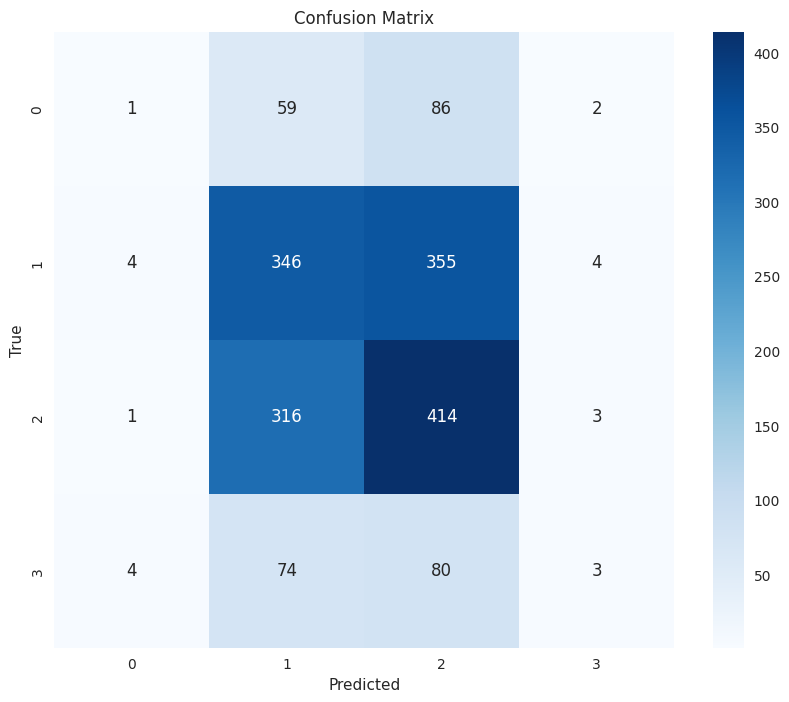

In [11]:
# Confusion Matrix 계산
cm = confusion_matrix(y_val, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Predict

In [21]:
data_path = "./data.csv"
all_df = pd.read_csv(data_path)

test_df = all_df.loc[all_df["_type"]=="test"].drop(columns=["_type"])

test_data = test_df.drop(["target", "ID"], axis=1)

y_test_pred = ensemble_model.predict(test_data)
y_test_pred = y_test_pred.astype(int)

dir_path = "/data/ephemeral/home/data"
submission_df = pd.read_csv(f"{dir_path}/test.csv")
submission_df = submission_df.assign(target=y_test_pred)
submission_df.to_csv("output.csv", index=False)

print(submission_df.target.value_counts())
submission_df

2    1527
1    1176
0      73
3      16
Name: target, dtype: int64


,ID,target
0,2024-01-01 00:00:00,2
1,2024-01-01 01:00:00,1
2,2024-01-01 02:00:00,2
3,2024-01-01 03:00:00,2
4,2024-01-01 04:00:00,1
...,...,...
2787,2024-04-26 03:00:00,1
2788,2024-04-26 04:00:00,2
2789,2024-04-26 05:00:00,2
2790,2024-04-26 06:00:00,1
